<a href="https://colab.research.google.com/github/ajay-del-bot/Sentiment-Analysis-on-COVID-19-Vaccination-Tweets/blob/main/VaccinationTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config Completer.use_jedi = False

In [ ]:
!pip install -U gensim

In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
import datetime

#for confusion matrix
import seaborn
from sklearn.metrics import confusion_matrix

In [ ]:
train = pd.read_csv("tweet_dataset.csv")
train.head(10)

,textID,sentiment,author,text,old_text,aux_id,new_sentiment,selected_text
0,1956967341,empty,xoshayzers,i know i was listenin to bad habit earlier and i started freakin at his part =[,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,p1000000000,NaN,NaN
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin on your call...,Layin n bed with a headache ughhhh...waitin on your call...,c811396dc2,negative,headache
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,Funeral ceremony...gloomy friday...,9063631ab1,negative,gloomy
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,wants to hang out with friends SOON!,2a815f151d,positive,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,"We want to trade with someone who has Houston tickets, but no one will.","@dannycastillo We want to trade with someone who has Houston tickets, but no one will.",82565a56d3,neutral,"We want to trade with someone who has Houston tickets, but no one will."
5,1956968477,worry,xxxPEACHESxxx,Re-pinging : why didn`t you go to prom? BC my bf didn`t like my friends,Re-pinging @ghostridah14: why didn't you go to prom? BC my bf didn't like my friends,a610d6b25b,negative,didn`t like my
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about an old friend who I want. but he`s married now. ****, & he wants me 2! scandalous!","I should be sleep, but im not! thinking about an old friend who I want. but he's married now. damn, &amp; he wants me 2! scandalous!",p1000000001,NaN,NaN
7,1956968636,worry,mcsleazy,Hmmm. http://www.djhero.com/ is down,Hmmm. http://www.djhero.com/ is down,2dfbe0b7fb,negative,NaN
8,1956969035,sadness,nic0lepaula,Charlene my love. I miss you,@charviray Charlene my love. I miss you,cc22eca4c5,negative,Charlene my love. I miss you
9,1956969172,sadness,Ingenue_Em,I`m sorry at least it`s Friday?,@kelcouch I'm sorry at least it's Friday?,6d846d7d50,negative,NaN


In [ ]:
train['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
train['new_sentiment'].unique()

array([nan, 'negative', 'positive', 'neutral'], dtype=object)

In [ ]:
train.shape

(40000, 8)

In [ ]:
train['new_sentiment'].value_counts()

neutral     12668
positive     9897
negative     8830
Name: new_sentiment, dtype: int64

In [ ]:
train = train[['selected_text', 'new_sentiment']]
train.head()

,selected_text,new_sentiment
0,NaN,NaN
1,headache,negative
2,gloomy,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral


In [ ]:
df_train = train.dropna(subset=['new_sentiment'])
len(df_train)

31395

In [ ]:
df_train = df_train.dropna(subset=['selected_text'])
len(df_train)

27767

In [ ]:
df_train.head(10)

,selected_text,new_sentiment
1,headache,negative
2,gloomy,negative
3,wants to hang out with friends SOON!,positive
4,"We want to trade with someone who has Houston tickets, but no one will.",neutral
5,didn`t like my,negative
8,Charlene my love. I miss you,negative
10,cant fall asleep,neutral
11,Choked on her retainers,negative
12,Ugh!,negative
13,realise what tourture,negative


### Data Cleaning

In [ ]:
import re

def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

temp = []
#Splitting pd.Series to list
data_to_list = df_train['selected_text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['headache',
 'gloomy',
 'wants to hang out with friends SOON!',
 'We want to trade with someone who has Houston tickets, but no one will.',
 'didn`t like my']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['headache'], ['gloomy'], ['wants', 'to', 'hang', 'out', 'with', 'friends', 'soon'], ['we', 'want', 'to', 'trade', 'with', 'someone', 'who', 'has', 'houston', 'tickets', 'but', 'no', 'one', 'will'], ['didn', 'like', 'my'], ['charlene', 'my', 'love', 'miss', 'you'], ['cant', 'fall', 'asleep'], ['choked', 'on', 'her', 'retainers'], ['ugh'], ['realise', 'what', 'tourture']]


In [ ]:
data = []
for i in range(len(data_words)):
    data.append(TreebankWordDetokenizer().detokenize(data_words[i]))
print(data[:10])

['headache', 'gloomy', 'wants to hang out with friends soon', 'we want to trade with someone who has houston tickets but no one will', 'didn like my', 'charlene my love miss you', 'cant fall asleep', 'choked on her retainers', 'ugh', 'realise what tourture']


In [ ]:
data = np.array(data)

### Label Encoding

In [ ]:
labels = np.array(df_train['new_sentiment'])
y = []
for i in range(len(labels)):
    if labels[i] == 'neutral':
        y.append(0)
    if labels[i] == 'negative':
        y.append(1)
    if labels[i] == 'positive':
        y.append(2)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

In [ ]:
labels

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

### Data Sequencing

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    0    0  323]
 [   0    0    0 ...    0    0 1639]
 [   0    0    0 ...   22  238  158]
 ...
 [   0    0    0 ...   26  128   20]
 [   0    0    0 ...    8    2  498]
 [   0    0    0 ... 1442 1076   37]]


### Splitting the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets,labels, test_size=0.15,random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

23601 4166 23601 4166


### Building a Model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))

model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint1])

Train on 23601 samples, validate on 4166 samples
Epoch 1/1
23601/23601 [==============================] - 62s 3ms/step - loss: 0.8051 - accuracy: 0.6551 - val_loss: 0.6332 - val_accuracy: 0.7679

Epoch 00001: val_accuracy improved from -inf to 0.76788, saving model to best_model1.hdf5


In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#model2 = keras.models.load_model('./best_model2.hdf5')
checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

Train on 23601 samples, validate on 4166 samples
Epoch 1/1
23601/23601 [==============================] - 78s 3ms/step - loss: 0.7810 - accuracy: 0.6576 - val_loss: 0.6062 - val_accuracy: 0.7655

Epoch 00001: val_accuracy improved from -inf to 0.76548, saving model to best_model2.hdf5


In [ ]:
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
model3.add(layers.GlobalMaxPooling1D())
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['acc'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model3.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint3])


Train on 23546 samples, validate on 7849 samples
Epoch 1/1
23546/23546 [==============================] - 9s 381us/step - loss: 1.0384 - acc: 0.5540 - val_loss: 0.9120 - val_acc: 0.5825


### Selecting a Model

In [ ]:
best_model = keras.models.load_model("./best_model2.hdf5")
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

Model accuracy:  0.765482485294342


In [ ]:
predictions = best_model.predict(X_test)

Confusion Matrix for Training Data:


<AxesSubplot:>

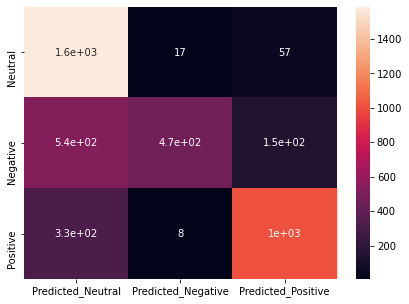

In [ ]:
print("Confusion Matrix for Training Data:")
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Predicted_Neutral','Predicted_Negative','Predicted_Positive'])
plt.figure(figsize=(7,5))
seaborn.heatmap(conf_matrix, annot=True)

<AxesSubplot:>

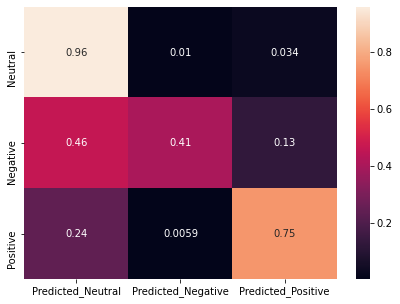

In [ ]:
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (7,5))
seaborn.heatmap(conf_matrix, annot=True)

## Applying the model to vaccination tweets

In [ ]:
df_tweets = pd.read_csv('vaccination_all_tweets.csv')
df_tweets.head(10)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA","Aggregator of Asian American news; scanning diverse sources 24/7/365. RT's, Follows and 'Likes' will fuel me 👩‍💻",2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s music junkie. Fascinated by meteorology and all things in the cloud. Opinions are my own.",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radio Network. Weeknights 7 Pacific-10 Eastern - Email comments/ideas to charles@charlesadlertonight.ca",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternative news source from citizen journalists that haven't sold out. Real news & real views,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False
5,1337852648389832708,Dee,"Birmingham, England","Gastroenterology trainee, Clinical Research Fellow in IBD, mother to human and fur baby, Canadian in Britain",2020-01-26 21:43:12,105,108,106,False,2020-12-12 20:11:42,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,NaN,Twitter for iPhone,0,0,False
6,1337851215875608579,Gunther Fehlinger,"Austria, Ukraine and Kosovo","End North Stream 2 now - the pipeline of corruption, funding Russias war against Ukraine,Georgia, Syria and political intervention in USA and EU must be stopped",2013-06-10 17:49:22,2731,5001,69344,False,2020-12-12 20:06:00,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",['vaccination'],Twitter Web App,0,4,False
7,1337850832256176136,Dr.Krutika Kuppalli,NaN,"ID, Global Health, VHF, Pandemic Prep, Emerging Infections, & Health Policy MD| U.S. Congress COVID-19 expert witness x 2 | ELBI 2020 @JHSPH_CHS",2019-03-25 04:14:29,21924,593,7815,True,2020-12-12 20:04:29,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,"['BidenHarris', 'Election2020']",Twitter for iPhone,2,22,False
8,1337850023531347969,Erin Despas,NaN,"Designing&selling on Teespring. Like 90s Disney tv movies, old school WWE. Dislikes Intolerance, hate, bigots and snakes https://t.co/fa5n4gEHgR",2009-10-30 17:53:54,887,1515,9639,False,2020-12-12 20:01:16,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,"['CovidVaccine', 'covid19', 'PfizerBioNTech', 'Moderna']",Twitter Web App,2,1,False
9,1337842295857623042

In [ ]:
df_tweets["text"].isnull().sum()

0

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = df_tweets["text"].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
temp[:5]

['Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech ',
 'While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort weve ev… ',
 '#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… ',
 'Facts are immutable, Senator, even when youre not ethically sturdy enough to acknowledge them. (1) You were born i… ',
 'Explain to me again why we need a vaccine #whereareallthesickpeople #PfizerBioNTech… ']

In [ ]:
data_words = list(sent_to_words(temp))
print(data_words[:10])

[['same', 'folks', 'said', 'daikon', 'paste', 'could', 'treat', 'cytokine', 'storm', 'pfizerbiontech'], ['while', 'the', 'world', 'has', 'been', 'on', 'the', 'wrong', 'side', 'of', 'history', 'this', 'year', 'hopefully', 'the', 'biggest', 'vaccination', 'effort', 'weve', 'ev'], ['coronavirus', 'sputnikv', 'astrazeneca', 'pfizerbiontech', 'moderna', 'covid_', 'russian', 'vaccine', 'is', 'created', 'to', 'last', 'years'], ['facts', 'are', 'immutable', 'senator', 'even', 'when', 'youre', 'not', 'ethically', 'sturdy', 'enough', 'to', 'acknowledge', 'them', 'you', 'were', 'born'], ['explain', 'to', 'me', 'again', 'why', 'we', 'need', 'vaccine', 'pfizerbiontech'], ['does', 'anyone', 'have', 'any', 'useful', 'advice', 'guidance', 'for', 'whether', 'the', 'covid', 'vaccine', 'is', 'safe', 'whilst', 'breastfeeding'], ['it', 'is', 'bit', 'sad', 'to', 'claim', 'the', 'fame', 'for', 'success', 'of', 'vaccination', 'on', 'patriotic', 'competition', 'between', 'usa', 'canada', 'uk', 'and'], ['there'

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(TreebankWordDetokenizer().detokenize(data_words[i]))
print(data[:10])

['same folks said daikon paste could treat cytokine storm pfizerbiontech', 'while the world has been on the wrong side of history this year hopefully the biggest vaccination effort weve ev', 'coronavirus sputnikv astrazeneca pfizerbiontech moderna covid_ russian vaccine is created to last years', 'facts are immutable senator even when youre not ethically sturdy enough to acknowledge them you were born', 'explain to me again why we need vaccine pfizerbiontech', 'does anyone have any useful advice guidance for whether the covid vaccine is safe whilst breastfeeding', 'it is bit sad to claim the fame for success of vaccination on patriotic competition between usa canada uk and', 'there have not been many bright days in but here are some of the best bidenharris winning election', 'covid vaccine you getting it covidvaccine covid pfizerbiontech moderna', 'covidvaccine states will start getting covid vaccine monday us says pakustv nyc healthcare globalgoals']


In [ ]:
data = np.array(data)
df_tweets['sentiment'] = np.nan

### Applying our model to vaccination set

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
for i in range(len(temp)):
    sequence = tokenizer.texts_to_sequences([temp[i]])
    test = pad_sequences(sequence, maxlen=max_len)
    df_tweets["sentiment"][i] = sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]
    if (i % 461 == 0):
        percentage = i/len(temp) * 100
        formatted_percentage = "{:.0f}".format(percentage)
        print(formatted_percentage,"%")

0 %
1 %
1 %
2 %
2 %
3 %
4 %
4 %
5 %
5 %
6 %
6 %
7 %
8 %
8 %
9 %
9 %
10 %
11 %
11 %
12 %
12 %
13 %
14 %
14 %
15 %
15 %
16 %
16 %
17 %
18 %
18 %
19 %
19 %
20 %
21 %
21 %
22 %
22 %
23 %
24 %
24 %
25 %
25 %
26 %
26 %
27 %
28 %
28 %
29 %
29 %
30 %
31 %
31 %
32 %
32 %
33 %
34 %
34 %
35 %
35 %
36 %
36 %
37 %
38 %
38 %
39 %
39 %
40 %
41 %
41 %
42 %
42 %
43 %
44 %
44 %
45 %
45 %
46 %
47 %
47 %
48 %
48 %
49 %
49 %
50 %
51 %
51 %
52 %
52 %
53 %
54 %
54 %
55 %
55 %
56 %
57 %
57 %
58 %
58 %
59 %
59 %
60 %
61 %
61 %
62 %
62 %
63 %
64 %
64 %
65 %
65 %
66 %
67 %
67 %
68 %
68 %
69 %
69 %
70 %
71 %
71 %
72 %
72 %
73 %
74 %
74 %
75 %
75 %
76 %
77 %
77 %
78 %
78 %
79 %
79 %
80 %
81 %
81 %
82 %
82 %
83 %
84 %
84 %
85 %
85 %
86 %
87 %
87 %
88 %
88 %
89 %
89 %
90 %
91 %
91 %
92 %
92 %
93 %
94 %
94 %
95 %
95 %
96 %
97 %
97 %
98 %
98 %
99 %
99 %


In [ ]:
pd.set_option('display.max_colwidth', None)
df_tweets[["text", "sentiment"]].head(50)

,text,sentiment
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,Neutral
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",Neutral
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,Neutral
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",Neutral
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,Neutral
5,Does anyone have any useful advice/guidance for whether the COVID vaccine is safe whilst breastfeeding?… https://t.co/EifsyQoeKN,Neutral
6,"it is a bit sad to claim the fame for success of #vaccination on patriotic competition between USA, Canada, UK and… https://t.co/IfMrAyGyTP",Neutral
7,There have not been many bright days in 2020 but here are some of the best \n1. #BidenHarris winning #Election2020… https://t.co/77u4f8XXfx,Neutral
8,Covid vaccine; You getting it?\n\n #CovidVaccine #covid19 #PfizerBioNTech #Moderna,Positive
9,"#CovidVaccine \n\nStates will start getting #COVID19Vaccine Monday, #US says \n#pakustv #NYC #Healthcare #GlobalGoals… https://t.co/MksOvBvs5w",Neutral


In [ ]:
csv_data = df_tweets.to_csv('output.csv', index=True)

In [ ]:
df_tweets['sentiment'].value_counts()

Neutral     74844
Positive     3210
Negative      265
Name: sentiment, dtype: int64